# Ayudantía 3: Magister en Ciencia de Datos
## Series de Tiempo

Ayudante: Bladimir Morales

In [81]:
#%pip install darts

In [82]:
# Import necessary libraries
import numpy as np
import pandas as pd
from darts import TimeSeries
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

# Base de datos ICAP

El objetivo es estudiar el índice de consumo de agua potable (ICAP) mensual, con datos disponibles desde enero de 1990 hasta mayo de 2024 (412 observaciones). El ICAP es un indicador que refleja la evolución y el comportamiento del consumo de agua potable en los sectores privado y público, tomando como año base 1990 (índice igual a 100). Las variaciones posteriores representan incrementos o decrementos en el consumo mensual respecto al año base.

In [105]:
df = pd.read_table('icap_90_24.txt', header = None, decimal=',')
df.columns = ['icap']
display(df.head(6))
df.info()

,icap
0,102.45
1,96.72
2,106.45
3,103.26
4,100.50
5,96.01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412 entries, 0 to 411
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   icap    412 non-null    float64
dtypes: float64(1)
memory usage: 3.3 KB


In [106]:
# Crea una columna 'fecha' con fechas mensuales desde enero de 1990 hasta abril de 2024.
# freq='MS' indica que las fechas corresponden al **inicio de cada mes** ("Month Start")
df['fecha'] = pd.date_range(start='1990-01', end='2024-04', freq='MS')

# Establece la columna 'fecha' como índice del DataFrame, lo que facilita operaciones temporales
df.set_index('fecha', inplace=True)

# Asegura que el índice del DataFrame esté en formato datetime para garantizar compatibilidad con funciones de series de tiempo
df.index = pd.to_datetime(df.index)

# Muestra las primeras 10 filas del DataFrame para inspección
display(df.head(10))

# Convierte la columna 'icap' del DataFrame en un objeto TimeSeries de la librería Darts
# Esto permite aplicar modelos de series temporales más fácilmente
df_series = TimeSeries.from_series(df['icap'])

# Divide la serie temporal en dos subconjuntos: entrenamiento y validación
# El punto de corte es el 1 de enero de 2023; todo antes es entrenamiento
df_train, df_val = df_series.split_before(pd.Timestamp('2023-01-01'))

# Extrae los valores del conjunto de entrenamiento como un arreglo NumPy
# squeeze() elimina dimensiones innecesarias del array (por ejemplo, de (n, 1) a (n,))
train_data_np = df_train.values().squeeze()

# Convierte los datos de entrenamiento a un DataFrame de pandas para procesamiento 
# adicional (por ejemplo, modelado o visualización)
train_data = pd.DataFrame(train_data_np)


,icap
fecha,
1990-01-01,102.45
1990-02-01,96.72
1990-03-01,106.45
1990-04-01,103.26
1990-05-01,100.50
1990-06-01,96.01
1990-07-01,90.98
1990-08-01,98.82
1990-09-01,101.21


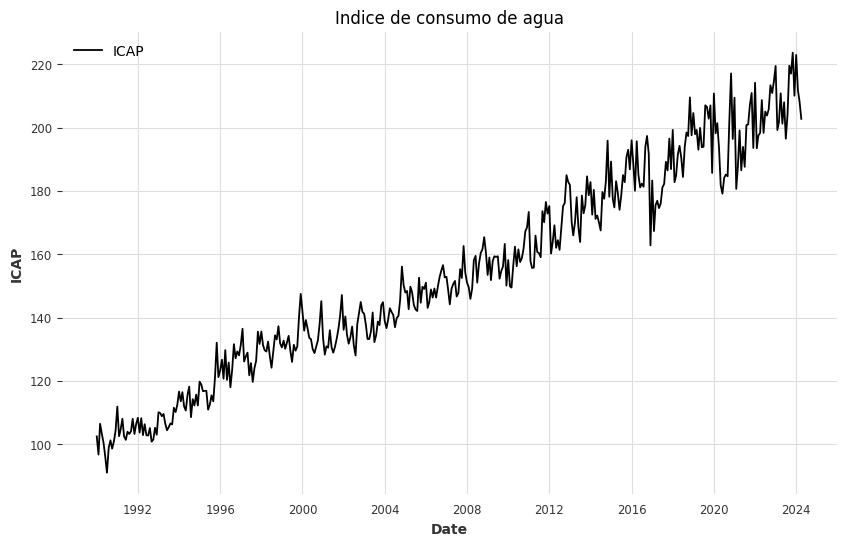

In [107]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['icap'], label='ICAP')
plt.title('Indice de consumo de agua')
plt.xlabel('Date')
plt.ylabel('ICAP')
plt.legend()
plt.show()

In [108]:
# seasonal_decompose: Se va a descomponer la serie temporal 'train_data' en sus componentes: 
# tendencia, estacionalidad y residuo.
# model='additive' asume que la serie se puede expresar de manera aditiva: 
#          y = tendencia + estacionalidad + residuo
# period=12 indica que hay una estacionalidad anual con datos mensuales (12 meses)
# extrapolate_trend='freq' permite extrapolar la tendencia hasta los extremos para evitar valores NaN
decomposition_result = seasonal_decompose(train_data, model='additive', period=12, extrapolate_trend='freq')

# Extrae la componente de tendencia y elimina los valores faltantes (NaN)
trend = decomposition_result.trend.dropna()

# Extrae la componente estacional y elimina los valores faltantes
seasonal = decomposition_result.seasonal.dropna()

# Extrae la componente de residuo (ruido) y elimina los valores faltantes
residual = decomposition_result.resid.dropna()

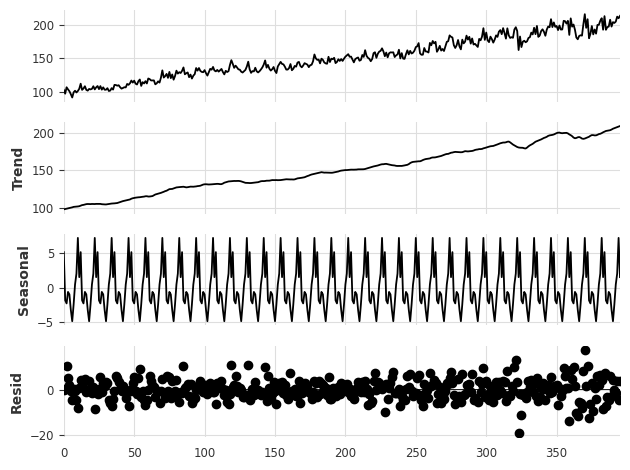

In [109]:
decomposition_result.plot()
plt.show()

In [111]:
# Genera una matriz de características X con los índices temporales de la tendencia como valores enteros (0, 1, 2, ...)
# reshape(-1, 1) convierte el array en una matriz columna (necesario para sklearn)
X = np.arange(len(trend)).reshape(-1, 1)

# Vector objetivo 'y', contiene los valores de la tendencia
y = trend.values

# Se crea un transformador de características polinómicas de grado 3
# Esto permite ajustar un modelo no lineal a la tendencia
poly = PolynomialFeatures(degree=3)

# Transforma X para incluir términos polinómicos hasta grado 3: [1, x, x^2, x^3]
X_poly = poly.fit_transform(X)

# Se inicializa el modelo de regresión lineal
regression_model = LinearRegression()

# Se entrena el modelo usando los predictores polinómicos y la tendencia observada
regression_model.fit(X_poly, y)

# Se genera un rango de fechas mensuales desde enero 2023 hasta abril 2024
# freq='MS' indica inicio de cada mes
dates_jan_abr = pd.date_range(start='2023-01', end='2024-04', freq='MS')
display(regression_model.coef_)
display(dates_jan_abr)

array([ 0.00000000e+00,  3.05165915e-01, -3.73202761e-04,  7.55535936e-07])

DatetimeIndex(['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
               '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',
               '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01',
               '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01'],
              dtype='datetime64[ns]', freq='MS')

In [113]:
# Se crea una matriz de índices futuros que continúa desde donde terminó 'trend'
X_future = np.arange(len(trend), len(trend) + len(dates_jan_abr)).reshape(-1, 1)

# Se aplican las mismas transformaciones polinómicas a los datos futuros
X_future_poly = poly.transform(X_future)

# Se predice la tendencia futura usando el modelo entrenado
predicted_trend = regression_model.predict(X_future_poly)
predicted_trend


array([208.18571243, 208.55126726, 208.91787537, 209.28554129,
       209.65426956, 210.02406472, 210.39493128, 210.76687379,
       211.13989679, 211.51400479, 211.88920235, 212.26549398,
       212.64288423, 213.02137762, 213.40097869, 213.78169198])

In [ ]:
# Agrupa la estacionalidad por índice (ej. mes) y calcula el promedio por mes
# Esto crea un patrón estacional promedio mensual
#seasonality_by_month = seasonal.groupby(seasonal.index).mean()

# Se define el orden de los meses (asume 16 valores futuros: 2023-01 a 2024-04)
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

# Se obtiene el patrón estacional correspondiente a los meses futuros
# Se usa .loc para seleccionar los valores de estacionalidad por mes
future_seasonality = seasonal.loc[months].values#.flatten()
display(future_seasonality)


array([-1.840787  , -2.28645681, -0.6296645 , -0.98582674, -3.21060008,
       -4.85726394, -2.41359875,  0.44487705,  2.01275942,  7.15753572,
        1.50222364,  5.106802  , -1.840787  , -2.28645681, -0.6296645 ,
       -0.98582674])

In [114]:

# Se suma la tendencia futura y la estacionalidad para obtener el pronóstico (sin residuos)
forecast_without_residuals = predicted_trend + future_seasonality

# Se convierte el pronóstico en una serie temporal con el índice de fechas correspondiente
forecast_without_residuals_series = pd.Series(forecast_without_residuals, index=dates_jan_abr)
forecast_without_residuals_series


2023-01-01    206.344925
2023-02-01    206.264810
2023-03-01    208.288211
2023-04-01    208.299715
2023-05-01    206.443669
2023-06-01    205.166801
2023-07-01    207.981333
2023-08-01    211.211751
2023-09-01    213.152656
2023-10-01    218.671541
2023-11-01    213.391426
2023-12-01    217.372296
2024-01-01    210.802097
2024-02-01    210.734921
2024-03-01    212.771314
2024-04-01    212.795865
Freq: MS, dtype: float64

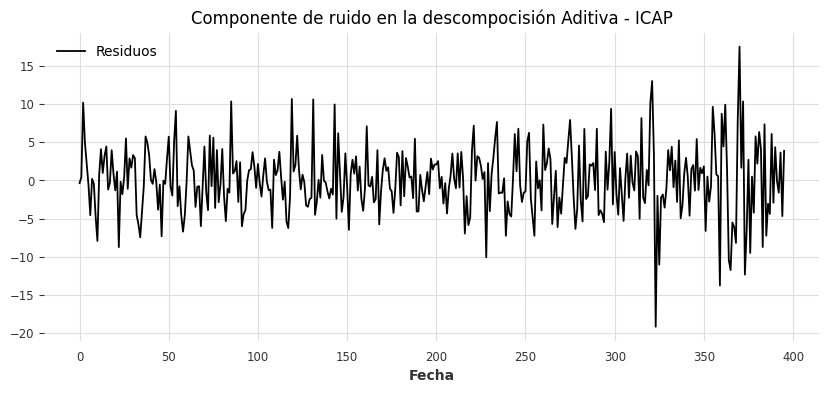

In [115]:
plt.figure(figsize=(10, 4))
plt.plot(residual, label='Residuos')
plt.title('Componente de ruido en la descompocisión Aditiva - ICAP')
plt.xlabel('Fecha')
plt.legend()
plt.show()

Test de Ljung-Box

$H_0:$ Hay ruido blanco (No, existe autocorrelación significativa en los residuos)

$H_1:$ No hay ruido blanco (Si, existe autocorrelación significativa en los residuos)

In [120]:
lb_test = acorr_ljungbox(residual, lags=[10], return_df=True)# Prueba para solo el lag 10 si quisiera del 1 al 10 lags=10
p_value = lb_test['lb_pvalue'].values[0]
print(lb_test)
print(p_value)

      lb_stat     lb_pvalue
10  75.629976  3.587012e-12
3.587012477461282e-12


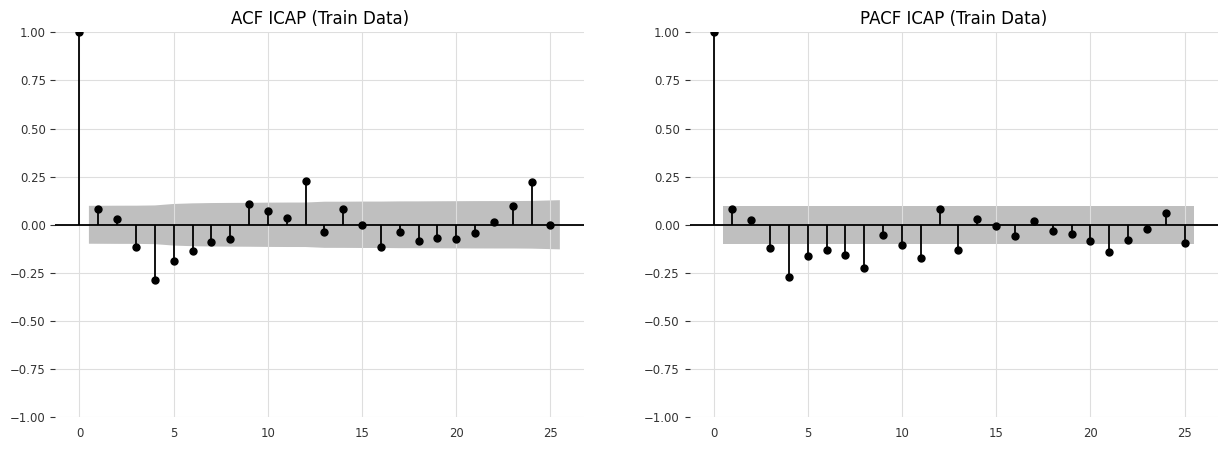

In [121]:
# Crear la figura y graficar ACF y PACF de train_data['asistentes']
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(residual, lags=25, ax=axes[0])
axes[0].set_title('ACF ICAP (Train Data)')

plot_pacf(residual, lags=25, ax=axes[1])
axes[1].set_title('PACF ICAP (Train Data)')

plt.show()

In [122]:
model_1 = ARIMA(residual, order=(1, 0, 1))
results_1 = model_1.fit()
results_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                  396
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1146.009
Date:                Wed, 12 Nov 2025   AIC                           2300.018
Time:                        20:49:31   BIC                           2315.943
Sample:                             0   HQIC                          2306.327
                                - 396                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0227      0.241      0.094      0.925      -0.450       0.496
ar.L1          0.1447      0.449      0.322      0.747      -0.735       1.025
ma.L1         -0.0621      0.453     -0.137      0.891      -0.950       0.825
sigma2        19.1064      1.102     17.345      0.000      16.947      21.265
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                34.98
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.12   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [123]:
results_1.aic

2300.0176743975126

In [124]:
model_2 = ARIMA(residual, order=(2, 0, 2))
results_2 = model_2.fit()
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                  396
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1091.162
Date:                Wed, 12 Nov 2025   AIC                           2194.323
Time:                        20:52:32   BIC                           2218.212
Sample:                             0   HQIC                          2203.787
                                - 396                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.003     -0.218      0.828      -0.007       0.005
ar.L1          1.4861      0.065     23.026      0.000       1.360       1.613
ar.L2         -0.6961      0.047    -14.832      0.000      -0.788      -0.604
ma.L1         -1.6356      0.492     -3.323      0.001      -2.600      -0.671
ma.L2          0.6357      0.305      2.086      0.037       0.038       1.233
sigma2        14.2714      7.633      1.870      0.062      -0.688      29.231
===================================================================================
Ljung-Box (L1) (Q):                   1.18   Jarque-Bera (JB):                46.19
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               2.31   Skew:                             0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [125]:
results_2.aic

2194.323449345745

In [126]:
model_3 = ARIMA(residual, order=(3, 0, 3))
results_3 = model_3.fit()
results_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                  396
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -1144.760
Date:                Wed, 12 Nov 2025   AIC                           2305.521
Time:                        20:53:31   BIC                           2337.372
Sample:                             0   HQIC                          2318.139
                                - 396                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0548      0.209      0.262      0.793      -0.355       0.465
ar.L1         -0.3604      0.662     -0.545      0.586      -1.657       0.936
ar.L2          0.4707      0.891      0.528      0.597      -1.275       2.216
ar.L3          0.8847      0.585      1.512      0.131      -0.262       2.032
ma.L1          0.3997      1.999      0.200      0.842      -3.519       4.319
ma.L2         -0.4584      2.790     -0.164      0.870      -5.928       5.011
ma.L3         -0.9405      1.874     -0.502      0.616      -4.613       2.732
sigma2        18.9846     25.337      0.749      0.454     -30.675      68.645
===================================================================================
Ljung-Box (L1) (Q):                   0.93   Jarque-Bera (JB):                25.82
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               2.01   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [127]:
results_3.aic

2305.5207938167396

In [128]:
model_4 = ARIMA(residual, order=(4, 0, 4))
results_4 = model_4.fit()
results_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                  396
Model:                 ARIMA(4, 0, 4)   Log Likelihood               -1083.473
Date:                Wed, 12 Nov 2025   AIC                           2186.946
Time:                        20:55:22   BIC                           2226.760
Sample:                             0   HQIC                          2202.719
                                - 396                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.003     -0.138      0.890      -0.006       0.005
ar.L1          0.5290      0.083      6.344      0.000       0.366       0.692
ar.L2         -0.2351      0.053     -4.430      0.000      -0.339      -0.131
ar.L3          0.7233      0.058     12.455      0.000       0.609       0.837
ar.L4         -0.6708      0.049    -13.577      0.000      -0.768      -0.574
ma.L1         -0.6937      1.240     -0.559      0.576      -3.124       1.737
ma.L2          0.0970      0.401      0.242      0.809      -0.689       0.883
ma.L3         -0.9269      0.524     -1.770      0.077      -1.953       0.100
ma.L4          0.5236      0.641      0.817      0.414      -0.733       1.780
sigma2        13.7762     17.736      0.777      0.437     -20.985      48.537
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                51.99
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               2.14   Skew:                             0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [129]:
results_4.aic

2186.9457217769423

In [130]:
model_5 = ARIMA(residual, order=(0, 0, 0))
results_5 = model_5.fit()
results_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                  396
Model:                          ARIMA   Log Likelihood               -1147.384
Date:                Wed, 12 Nov 2025   AIC                           2298.768
Time:                        20:56:58   BIC                           2306.731
Sample:                             0   HQIC                          2301.922
                                - 396                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0219      0.220      0.099      0.921      -0.410       0.454
sigma2        19.2399      1.047     18.379      0.000      17.188      21.292
===================================================================================
Ljung-Box (L1) (Q):                   2.71   Jarque-Bera (JB):                32.90
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               2.07   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [131]:
results_5.aic

2298.767697591723